[My message](https://twitter.com/hwajung_kang/status/1303446084942016521?s=11)

In [2]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.test.mock import FakeMontreal
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import *
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
import qiskit.tools.jupyter

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Find Ground State Energy
Consider the spin-spin coupling Hamiltonian for the hyperfine splitting, $Hss = A(XX + YY + ZZ)$ where $X, Y, Z$ are Pauli operators and $A = 1.47e^{-6} eV$.

In [3]:
Energy_g = -4.41e-6
Energy_u = 1.47e-6
A = 1.47e-6

sim = Aer.get_backend('qasm_simulator')
shots = 20000

# I. No noise

## A. QPE

In [4]:
t = 5 # number of counting qubits

In [5]:
#### create Hss op
n, time = 10, 2 # parameters for trotterization

qc = QuantumCircuit(2)
for j in range(n):
    
    qc.cx(0,1)
    qc.rx(-time/n,0)
    qc.cx(0,1)
    
    qc.s(range(2))
    qc.cx(0,1)
    qc.rx(-time/n,0)
    qc.cx(0,1)
    qc.s(range(2))
    
    qc.h(range(2))
    qc.cx(0,1)
    qc.rx(-time/n,0)
    qc.cx(0,1)
    qc.h(range(2))    
        
# make control-Hss of the circuit
H_ss = qc.to_gate()
H_ss.label = 'Hss'
cH_ss = H_ss.control()

In [6]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [7]:
qpe = QuantumCircuit(t+2, t)
qpe.h(range(t))
###
qpe.h(t)
qpe.x(t+1)
####
for idx in range(t):
    for _ in range(2**idx):
        qpe.append(cH_ss, [idx]+[*range(t,t+2)])

qft_dag = qft(t).to_gate().inverse()  
qft_dag.label = 'QFT+'

qpe.append(qft_dag, range(t))
qpe.barrier()  
qpe.measure(range(t), range(t))
#qpe.draw('mpl')

In [8]:
count_qpe = execute(qpe, sim, shots=shots).result().get_counts()

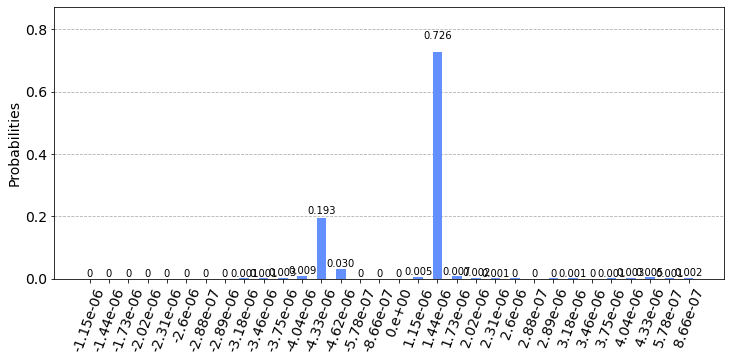

In [9]:
phi_QPE = np.array([round(int(key, 2)*2*np.pi/2**t, 3) for key in list(count_qpe.keys())])
phi_QPE[phi_QPE > np.pi] = np.round(phi_QPE[phi_QPE > np.pi]- 2*np.pi, 3)
Energy_QPE = [np.format_float_scientific(A*item, precision=2) for item in phi_QPE]
key_QPE = list(map(str, Energy_QPE))
countQPE = dict(zip(key_QPE, count_qpe.values()))
plot_histogram(countQPE, figsize=(12,5))

## B. I(Q)PE

In [10]:
q = QuantumRegister(3)
c = ClassicalRegister(t)

ipe = QuantumCircuit(q,c)
###
ipe.h(q[1])
ipe.x(q[2])
###

num = np.array([2**i for i in reversed(range(t))], dtype=int)

for i in range(t):
    ipe.h(q[0])
    for j in range(num[i]):
        ipe.append(cH_ss, q[:])
    for j in range(1,2**i):
        if i==0:
            pass
        else:
            ipe.u1(-2*np.pi*j/2**(i+1),q[0]).c_if(c,j)   
    ipe.h(q[0])
    ipe.measure(q[0], c[i])
    ipe.reset(q[0])

#ipe.draw('mpl')

In [11]:
count_ipe = execute(ipe, sim, shots=shots).result().get_counts()

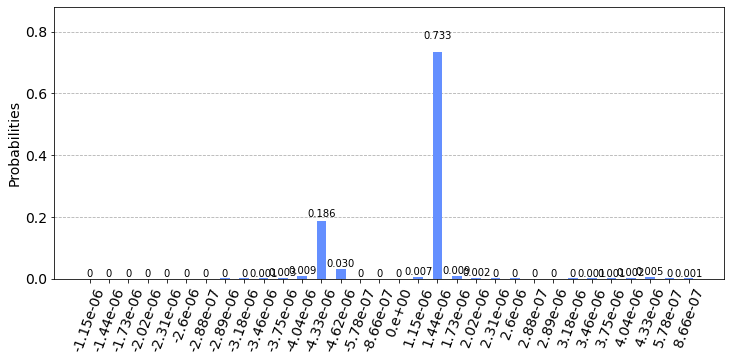

In [12]:
phi_IPE = np.array([round(int(key, 2)*2*np.pi/2**t, 3) for key in list(count_ipe.keys())])
phi_IPE[phi_IPE > np.pi] = np.round(phi_IPE[phi_IPE > np.pi]- 2*np.pi, 3)
Energy_IPE = [np.format_float_scientific(A*item, precision=2) for item in phi_IPE]
key_IPE = list(map(str, Energy_IPE))
countIPE = dict(zip(key_IPE, count_ipe.values()))
plot_histogram(countIPE, figsize = (12,5))

### Plot QPE and IPE results together

True minimum Energy: -4.41e-06 eV


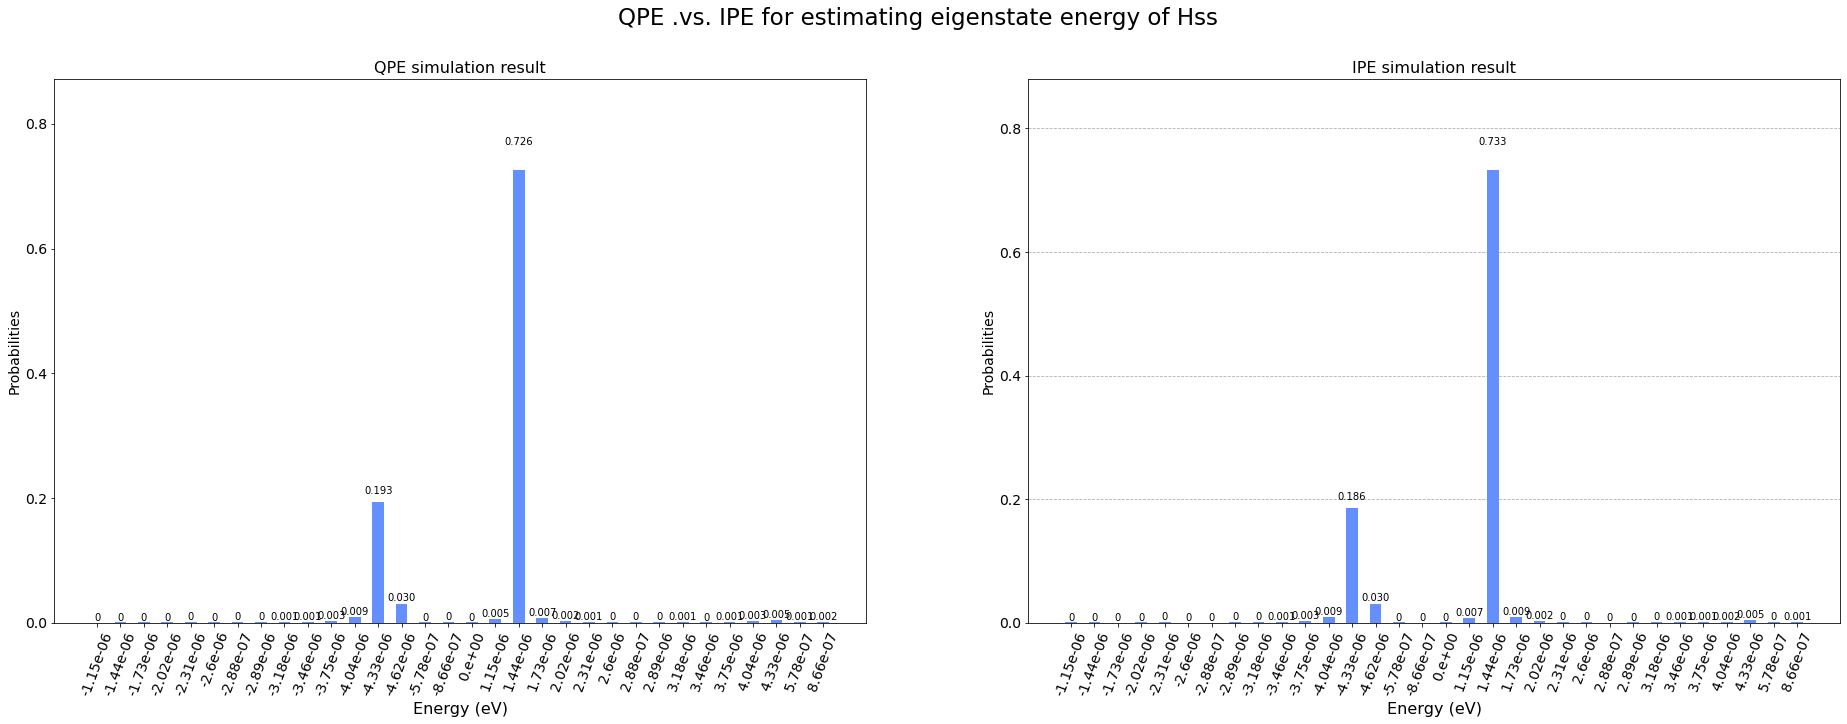

In [13]:
print('True minimum Energy: {} eV'.format(Energy_g))
fig, ax = plt.subplots(1, 2, figsize=(32,10))
fig.suptitle('QPE .vs. IPE for estimating eigenstate energy of Hss', fontsize=23)
plot_histogram(countQPE, ax=ax[0])
plot_histogram(countIPE, ax=ax[1])
ax[0].set_title('QPE simulation result', fontsize=16)
ax[0].set_xlabel('Energy (eV)', fontsize=16)
ax[1].set_title('IPE simulation result', fontsize=16)
ax[1].set_xlabel('Energy (eV)', fontsize=16)
plt.show()

## VQE

In [14]:
Hss = (1*X^X) + (1*Y^Y) +(1*Z^Z)

In [15]:
n_q = Hss.num_qubits
print(n_q)

2


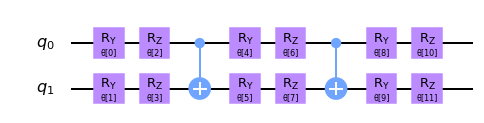

In [16]:
state = EfficientSU2(n_q, reps=2)
state.draw('mpl')

In [17]:
iters, energy = [], []
def callback(iteration, params, val_mean, val_std):
    iters.append(iteration)
    energy.append(val_mean)

In [18]:
sim_state = Aer.get_backend('statevector_simulator')

In [19]:
optimizer = COBYLA(maxiter=700)
result = VQE(var_form=state, operator=Hss, optimizer=optimizer,
              quantum_instance=sim_state, callback=callback).compute_minimum_eigenvalue()

True minimum Energy: -4.41e-06 eV
Estimated minimum Energy from VQE on a simulator: -4.41e-06 eV


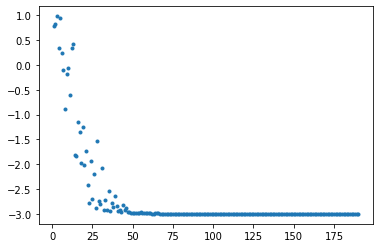

In [40]:
print('True minimum Energy: {} eV'.format(Energy_g))
print('Estimated minimum Energy from VQE on a simulator: {} eV'.format(np.format_float_scientific(A*result.eigenvalue, precision=3)))
plt.plot(iters, energy, '.')
plt.show()

# II. with Noise

In [21]:
backend = FakeMontreal()
backend;

In [22]:
noise_model = NoiseModel.from_backend(backend)

## A. QPE

In [23]:
QPE_trans = transpile(qpe, backend, optimization_level=3)
print(QPE_trans.depth())

36351


In [24]:
count_QPE_noise = execute(QPE_trans, sim, noise_model=noise_model).result().get_counts()

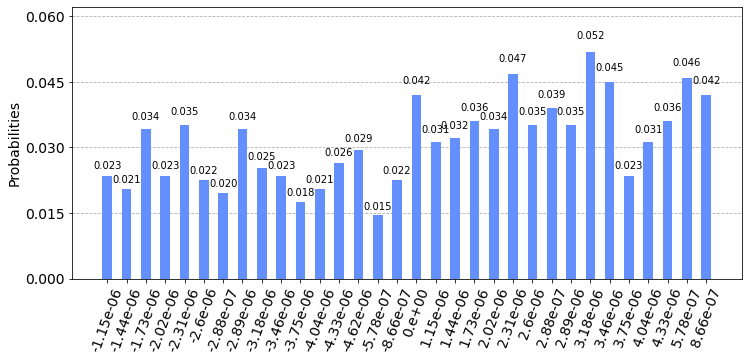

In [27]:
phi_QPE_noise = np.array([round(int(key, 2)*2*np.pi/2**t, 3) for key in list(count_QPE_noise.keys())])
phi_QPE_noise[phi_QPE_noise > np.pi] = np.round(phi_QPE_noise[phi_QPE_noise > np.pi]- 2*np.pi, 3)
Energy_QPE_noise = [np.format_float_scientific(A*item, precision=2) for item in phi_QPE_noise]
key_QPE_noise = list(map(str, Energy_QPE_noise))
countQPE_noise = dict(zip(key_QPE_noise, count_QPE_noise.values()))
plot_histogram(countQPE_noise, figsize=(12,5))

## B. IPE

In [28]:
IPE_trans = transpile(ipe, backend, initial_layout=[16, 19,20], optimization_level=3)
print(IPE_trans.depth())

37137


In [29]:
count_IPE_noise = execute(IPE_trans, sim, noise_model=noise_model).result().get_counts()

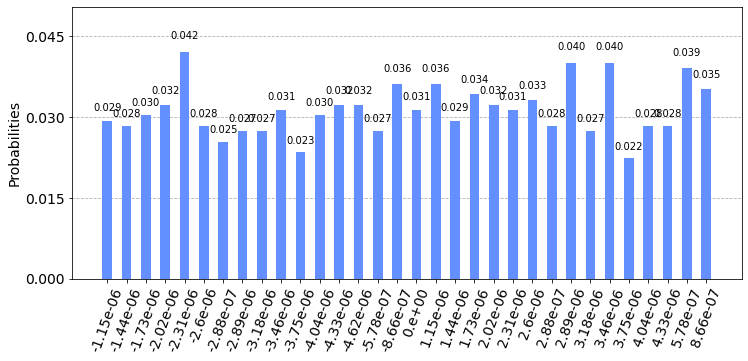

In [30]:
phi_IPE_noise = np.array([round(int(key, 2)*2*np.pi/2**t, 3) for key in list(count_IPE_noise.keys())])
phi_IPE_noise[phi_IPE_noise > np.pi] = np.round(phi_IPE_noise[phi_IPE_noise > np.pi]- 2*np.pi, 3)
Energy_IPE_noise = [np.format_float_scientific(A*item, precision=2) for item in phi_IPE_noise]
key_IPE_noise = list(map(str, Energy_IPE_noise))
countIPE_noise = dict(zip(key_IPE_noise, count_IPE_noise.values()))
plot_histogram(countIPE_noise, figsize = (12,5))

### Plot QPE and IPE results together

True minimum Energy: -4.41e-06 eV


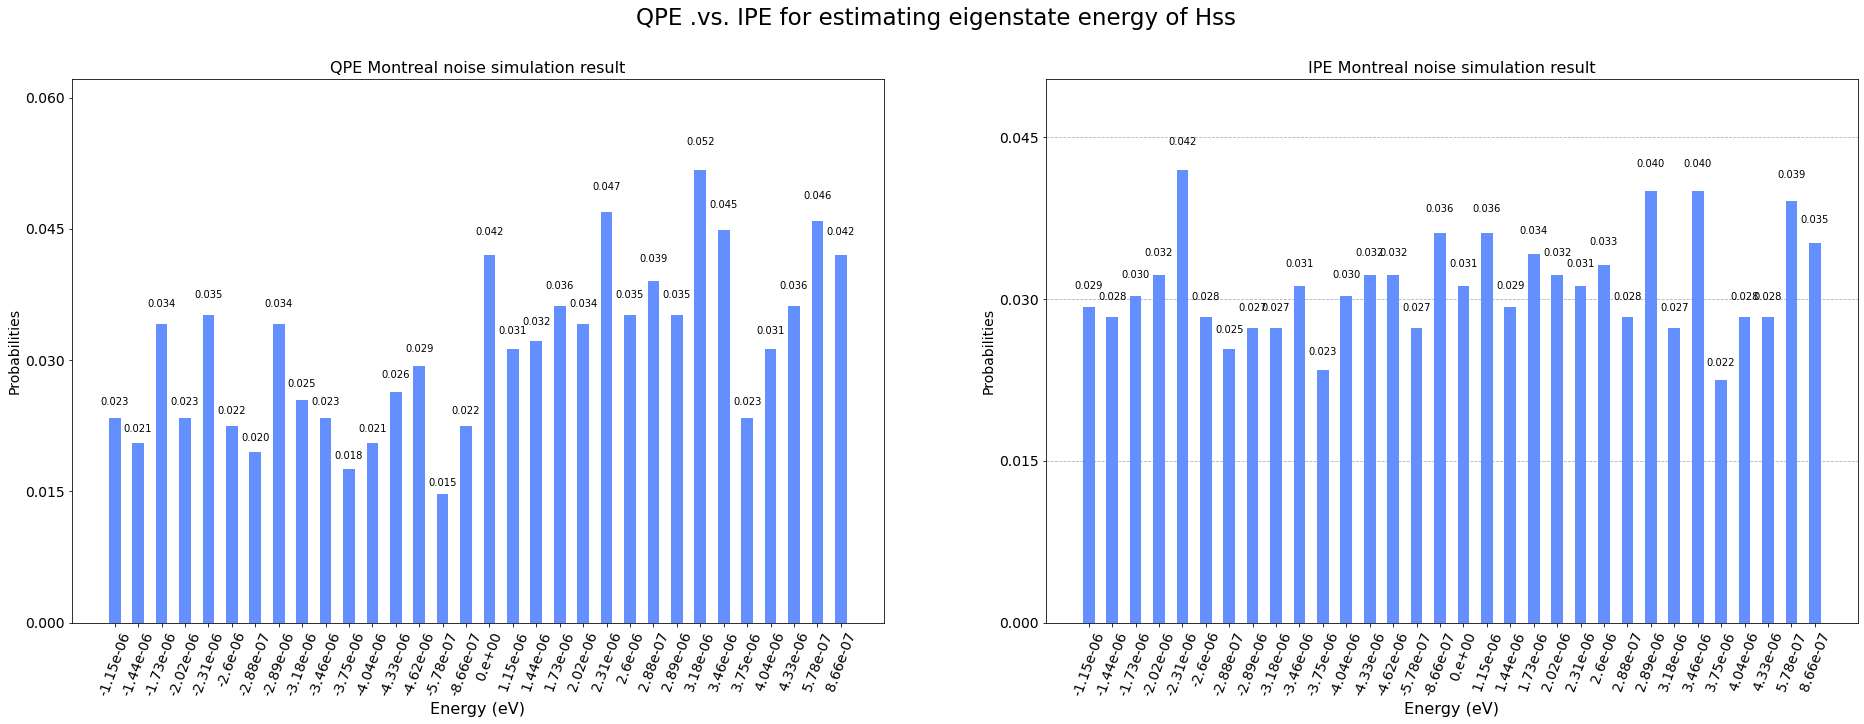

In [31]:
print('True minimum Energy: {} eV'.format(Energy_g))
fig, ax = plt.subplots(1, 2, figsize=(32,10))
fig.suptitle('QPE .vs. IPE for estimating eigenstate energy of Hss', fontsize=23)
plot_histogram(countQPE_noise, ax=ax[0])
plot_histogram(countIPE_noise, ax=ax[1])
ax[0].set_title('QPE Montreal noise simulation result', fontsize=16)
ax[0].set_xlabel('Energy (eV)', fontsize=16)
ax[1].set_title('IPE Montreal noise simulation result', fontsize=16)
ax[1].set_xlabel('Energy (eV)', fontsize=16)
plt.show()

## C. VQE

In [37]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-internal')

In [33]:
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_montreal")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [34]:
iters_noise, energy_noise = [], []
def callback_noise(iter_num, params, val_mean, val_std):
    iters_noise.append(iter_num)
    energy_noise.append(val_mean)

In [35]:
optimizer = SPSA(maxiter=300)
vqe = VQE(operator=Hss, var_form=state, optimizer=optimizer, callback=callback_noise)
ret =vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])

True minimum Energy: -4.41e-06 eV
Estimated minimum Energy from VQE on Montreal noise simulator: -4.013e-06 eV


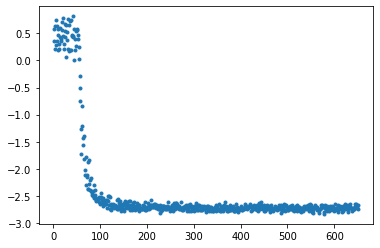

In [38]:
print('True minimum Energy: {} eV'.format(Energy_g))
print('Estimated minimum Energy from VQE on Montreal noise simulator: {} eV'.format(np.format_float_scientific(A*vqe_result, precision=3)))
plt.plot(iters_noise, energy_noise, '.')
plt.show()